# Machine Learning Tests on WWW

## Basic imports, setups

In [1]:
print("Have a great day!")
import os, time, sys
start_time = time.time()
import pandas as pd
import numpy as np
from itertools import accumulate
print("import sklearn")
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelBinarizer, scale
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.externals import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
print("import matplotlib")
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
%matplotlib inline
print("import torch")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
print("import xgboost")
from tqdm import tqdm
from xgboost import XGBClassifier
import xgboost as xgb
print("import ROOT + others")
import ROOT
print("Fix random number generators")
np.random.seed(24)
torch.manual_seed(24)
print("--- %.2f seconds ---" % (time.time() - start_time))

Have a great day!
import sklearn


/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


import matplotlib


/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


import torch
import xgboost
import ROOT + others
Welcome to JupyROOT 6.10/06
Fix random number generators
--- 21.97 seconds ---


## Data and import

In [2]:
def get_data(data_dir):
    fs = [data_dir + f for f in os.listdir(data_dir) if ('signal' in f or 'bkg' in f) and f[0] != '.']
    df = pd.DataFrame()
    for f in fs:
        print("adding", f)
        new_df = pd.read_csv(f)
        df = pd.concat([df, new_df], ignore_index = True)
        df.index = range(len(df))
    print("done merging data")
    return df

def add_cl_ix(df):
    df['is_sig'] = [1 if 'signal' in val else 0 for val in df.cl.values]
    return df

data_dir = '../data/' # Modify this
df_all = get_data(data_dir)
df_all = add_cl_ix(df_all)

adding ../data/bkg_WZlvll.csv
adding ../data/bkg_WZqqll.csv
adding ../data/bkg_Wtll.csv
adding ../data/bkg_Wtllat.csv
adding ../data/bkg_ZZllll.csv
adding ../data/bkg_ZZqqll.csv
adding ../data/bkg_ZZvvll.csv
adding ../data/bkg_stl.csv
adding ../data/bkg_stlat.csv
adding ../data/bkg_ttW0.csv
adding ../data/bkg_ttW1.csv
adding ../data/bkg_ttW2.csv
adding ../data/bkg_ttZ0.csv
adding ../data/bkg_ttZ1.csv
adding ../data/bkg_ttll.csv
adding ../data/signal_WmWpWm.csv
adding ../data/signal_WpWpWm.csv
done merging data


### Set the explicit flavor; add in fixed cuts

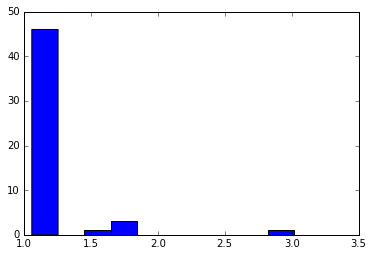

/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


181473 811690 639247
181473 811690 639247


In [3]:
## copy into 3 different dfs
df_0 = df_all.loc[df_all.SFOS == 0, :]
df_1 = df_all.loc[df_all.SFOS == 1, :]
df_2 = df_all.loc[df_all.SFOS == 2, :]
## quick check
#print(df_all.head())
plt.clf()
#print(df_all.loc[abs(df_all.weight) > 20, 'cl'])
plt.hist(df_all.loc[abs(df_all.weight) > 1, 'weight'])
plt.show()
##quick clean
df_0.loc[abs(df_0.weight) > 10, 'weight'] = 0
df_1.loc[abs(df_1.weight) > 10, 'weight'] = 0
df_2.loc[abs(df_2.weight) > 10, 'weight'] = 0
print(df_0.shape[0], df_1.shape[0], df_2.shape[0])
##add fixed cuts
#df_0 = df_0.query('Nbjet < 1')
#df_1 = df_1.query('Nbjet < 1')
#df_2 = df_2.query('Nbjet < 1')
#df_0 = df_0.query('Njet < 2')
#df_1 = df_1.query('Njet < 2')
#df_2 = df_2.query('Njet < 2')
##split training and testing
df_0_tr, df_0_te = train_test_split(df_0, test_size=0.2)
df_1_tr, df_1_te = train_test_split(df_1, test_size=0.2)
df_2_tr, df_2_te = train_test_split(df_2, test_size=0.2)
print(df_0.shape[0], df_1.shape[0], df_2.shape[0])

In [4]:
## Feature columns
## Need feature engineering -- add lepton transverse mass, and the extra lepton info

x_cols = ['l0_pt', 'l1_pt', 'l2_pt', 
          'l0_l1_m', 'l0_l1_pt', 'l0_l1_c', 'l0_l1_isEl', 
          'l1_l2_m', 'l1_l2_pt', 'l1_l2_c', 'l1_l2_isEl', 
          'l2_l0_m', 'l2_l0_pt', 'l2_l0_c', 'l2_l0_isEl', 
          'm_3l', 'pt_3l', 'mt_3l', 'mnew_3l', 'met_pt', 'met_phi', 'Njet'
         ]

x_cols_new = ["l0_m","l0_pt","l0_eta","l0_phi", "l0_isEl", "l0_c",
              "l1_m","l1_pt","l1_eta","l1_phi", "l1_isEl", "l1_c",
              "l2_m","l2_pt","l2_eta","l2_phi", "l2_isEl", "l2_c",
              "pt_3l","mt_3l", "mnew_3l", 
              "met_pt", "met_phi", 
              "Nmu", "Nel", "j0_pt",
             ]
#print(x_cols, x_cols_new, df.columns)

In [70]:
# def train(df, x_cols):
#     y_col = 'is_sig'
#     ##learning_rate: Analogous to learning rate in GBM
#     ##min_child_weight: min sum of weights of all obs required in a child. Used to control over-fitting. 
#     ##max_depth: Used to control over-fitting
#     ##max_leaf_nodes: Can be defined in place of max_depth.
#     ##gamma: Gamma specifies the minimum loss reduction required to make a split.
#     ##subsample: Lower values make the algorithm
#     ##reg_lambda: L2 regularization term on weights (analogous to Ridge regression)
#     ##reg_alpha: L1 regularization term on weight (analogous to Lasso regression)
#     model = XGBClassifier(nthread=-1, gamma=0.001, learning_rate=0.1, reg_alpha=0.5)
#     print('training...')
#     model.fit(df[x_cols].values, df[y_col].values, eval_metric="auc")
#     #model.fit(df[x_cols].values, df[y_col].values, sample_weight = df.weight.values)
#     #df['preds'] = model.predict_proba(df[x_cols].values)[:,1]
#     print('done training')
#     return df, model
# df_1, model = train(df_1, x_cols)

In [71]:
## A new more systematic approach
def modelfit(alg, dtrain, predictors, useTrainCV=True, param_grid={}, cv_folds=5, early_stopping_rounds=50):
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
#https://www.dataiku.com/learn/guide/code/python/advanced-xgboost-tuning.html    

    if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain["is_sig"].values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
        
        ##Randomized Search CV
        random_search = RandomizedSearchCV(alg, param_grid, n_iter=10, cv=3, refit=True, verbose=2, n_jobs=4)
        random_search.fit(dtrain[predictors], dtrain["is_sig"])
        report(random_search.cv_results_)
        
        ##Grid search CV
        #gsearch1 = GridSearchCV(estimator = alg, param_grid = param_grid, scoring='roc_auc',n_jobs=4, iid=False, cv=5)
        #gsearch1.fit(dtrain[predictors], dtrain["is_sig"], eval_metric="auc", early_stopping_rounds=30)
        #print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    else:
        #Fit the algorithm on the data
        alg.fit(dtrain[predictors], dtrain["is_sig"])
    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain["is_sig"].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain["is_sig"], dtrain_predprob))
    
    return True

    
def training(df, features, name="xgb_temp", optimize=False):
    
    param_grid = {
            'learning_rate': [.05, .3], 
            'max_depth': range(3, 9, 1), 
            #'gamma' : [0.01, .1], 
            #'subsample': [.5, .9], 
            #'colsample_bytree': [.5, .9]
    }
    
    xgb_temp = XGBClassifier(
        learning_rate = 0.1,
        max_depth = 5,
        min_child_weight=1,
        objective= 'binary:logistic',
        nthread=-1,
        scale_pos_weight=1,
        seed=24)
    
    if optimize:
        modelfit(xgb_temp, df, features, param_grid=param_grid)
        joblib.dump(param_grid.best_estimator_, name + ".parlib.dat")
    else:
        modelfit(xgb_temp, df, features, useTrainCV=False)
    
    ##save model
    joblib.dump(xgb_temp, name + ".joblib.dat")
    ##load model
    ##loaded_model = joblib.load("pima.joblib.dat")
    
    plt.clf()
    fig = plt.figure(figsize=(10,6))
    feat_imp = pd.Series(xgb_temp.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.savefig('../plots/feature_ranking_' + name + '.pdf')

    return xgb_temp


Model Report
Accuracy : 0.8357
AUC Score (Train): 0.867787

Model Report
Accuracy : 0.8531
AUC Score (Train): 0.913528

Model Report
Accuracy : 0.8896
AUC Score (Train): 0.908481


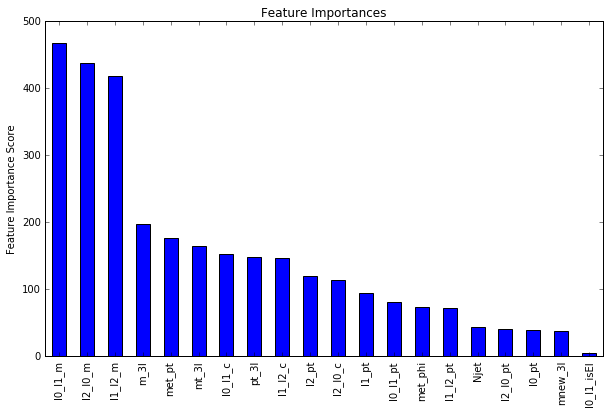

In [72]:
xgb_0 = training(df_0_tr, x_cols, name="xgb_0")
xgb_1 = training(df_1_tr, x_cols, name="xgb_1")
xgb_2 = training(df_2_tr, x_cols, name="xgb_2")

## Check output performance

In [73]:
#model = xgb1
df_0['preds'] = xgb_0.predict_proba(df_0[x_cols])[:,1]
df_1['preds'] = xgb_1.predict_proba(df_1[x_cols])[:,1]
df_2['preds'] = xgb_2.predict_proba(df_2[x_cols])[:,1]

In [74]:
def significance(S, B):
    #return S/np.sqrt(B)
    return np.sqrt(2 * ((S + B) * np.log(1 + S / B) - S))

def check_MLoutput(df, prename=""):
    plt.clf()
    x_bins = np.linspace(0, max(df.preds), 60)
    fig = plt.figure(figsize=(10,6))
    gs = gridspec.GridSpec(3, 1)
    ax = plt.subplot(gs[0,:])
    plt.title('XGBClassifier Separability')
    n_bkg,bins,paint = plt.hist(df[df.is_sig == 0].preds, bins=x_bins, weights=df[df.is_sig == 0].weight, color='r')
    plt.yscale('log')
    plt.ylabel(r'Weighted Background Counts', size=9)
    plt.legend(handles=[mpatches.Patch(color='red', label='Background')])
    ax1 = plt.subplot(gs[1,:])
    n_sig,bins,paint = plt.hist(df[df.is_sig == 1].preds, bins=x_bins, weights=df[df.is_sig == 1].weight, color='g')
    #plt.yscale('log')
    plt.ylabel(r'Weighted Signal Counts', size=9)
    plt.legend(handles=[mpatches.Patch(color='green', label='Signal')])
    ax2 = plt.subplot(gs[2,:])
    plt.bar(x_bins[:-1], significance(n_sig, n_bkg), width=x_bins[1] - x_bins[0], color='k')
    plt.ylabel(r'Significance', size=9)
    plt.xlabel('XGBoost output')
    #print(n_bkg, n_sig, significance(n_sig, n_bkg))
    n_bkg_sum = np.array(list(accumulate(reversed(n_bkg))))
    n_sig_sum = np.array(list(accumulate(reversed(n_sig))))
    sig_sum = significance(n_sig_sum, n_bkg_sum)
    #print(sig_sum)
    print("cut: %.2g; max sig : %.4g; Nsig : %.3g; Nbkg : %.3g" % 
          (x_bins[-np.argmax(sig_sum) - 1], sig_sum[np.argmax(sig_sum)], n_sig_sum[np.argmax(sig_sum)], n_bkg_sum[np.argmax(sig_sum)]))

    plt.tight_layout()
    #plt.show()
    plt.savefig('../plots/' + prename + 'preds_train.pdf')

    fpr, tpr, thresholds = metrics.roc_curve(df.is_sig.values, df.preds.values, pos_label=1)
    fig = plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr)
    plt.title('XGBClassifier ROC')
    plt.annotate('Area: ' + str(round(metrics.auc(fpr, tpr), 2)), xy=(.8,.2), xycoords='axes fraction')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('Bkg misidentification rate')
    plt.ylabel('Signal efficiency')
    #plt.show()
    plt.savefig('../plots/' + prename + 'roc_curve.pdf')
    print("Done!")

cut: 0.96; max sig : 0.7907; Nsig : 2.93; Nbkg : 12.8
Done!


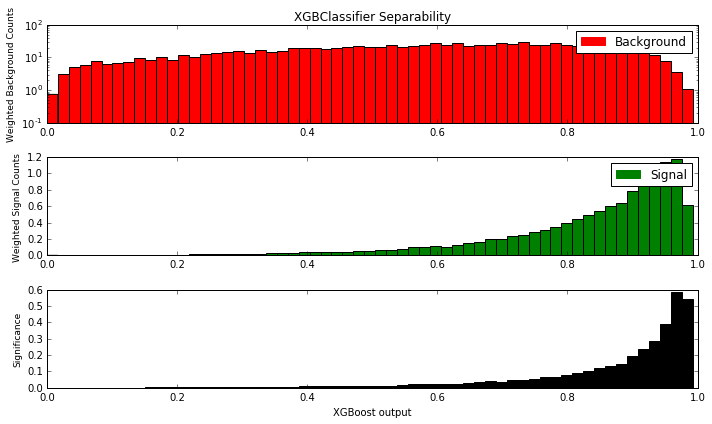

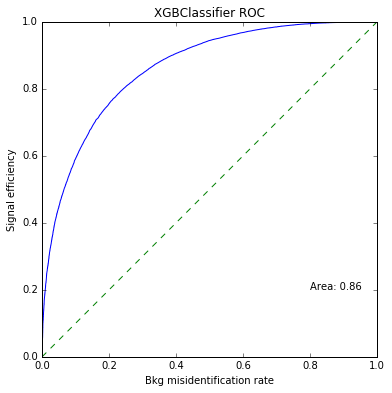

In [75]:
check_MLoutput(df_0, prename="SFOS0")

cut: 0.68; max sig : 0.5355; Nsig : 10.8; Nbkg : 401
Done!


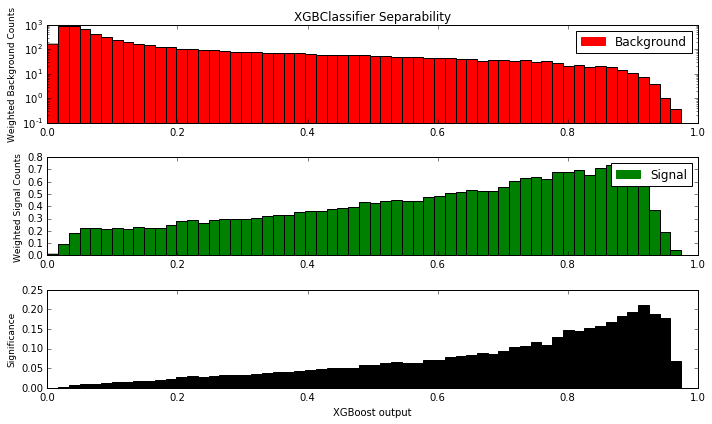

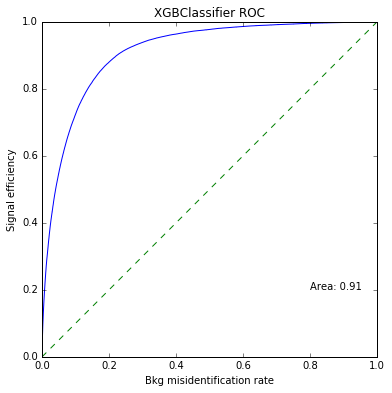

In [76]:
check_MLoutput(df_1, prename="SFOS1")

cut: 0.57; max sig : 0.3203; Nsig : 4.86; Nbkg : 229
Done!


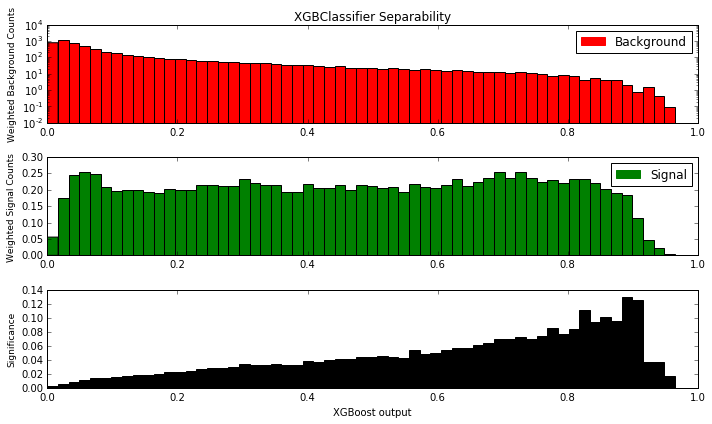

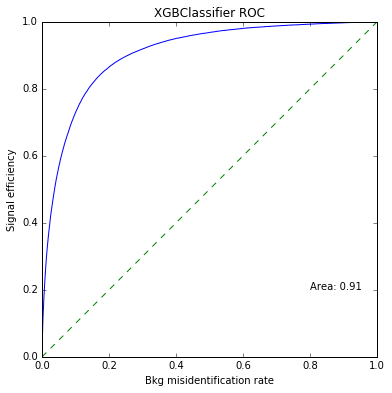

In [77]:
check_MLoutput(df_2, prename="SFOS2")

In [33]:
def interpret_MLoutput(df, prename=""):
    for var in tqdm(x_cols):
#         if "_" not in var:
#             continue
        if "l2_pt" in var:
            continue
        #print(var)
        colors = ['r', 'b']
        title  = {0: 'background', 1: 'signal'}

        plt.clf()
        f, axes = plt.subplots(1, 2, sharey=True)
        for sig in [0, 1]:        
            x = df[df['is_sig'] == sig][var]
            y = df[df['is_sig'] == sig]['preds']
            weight = df[df['is_sig'] == sig]['weight']
            #print("fill")
            if ("_m" in var):
                h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 120], [0, 1]])
            elif ("m_3l" in var):
                h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 500], [0, 1]])
            elif ("met_pt" in var):
                h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 400], [0, 1]])
            elif ("met_phi" in var):
                h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[-np.pi, np.pi], [0, 1]])
            elif ("pt" in var):
                h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 200], [0, 1]])
            elif ("mt" in var):
                h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 150], [0, 1]])
            else:
                h = axes[sig].hist2d(x, y, bins=[20, 16], range=[[min(x), max(x)], [0, 1]])
            axes[sig].set_ylabel('classifier output')
            axes[sig].set_xlabel(str(var))
            axes[sig].set_title(title[sig])
        plt.savefig("../plots/" + prename + str(var) + ".pdf")

 91%|█████████▏| 21/23 [00:13<00:01,  1.54it/s]/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████| 23/23 [00:24<00:00,  1.06s/it]


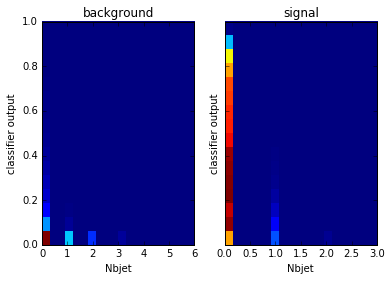

In [35]:
interpret_MLoutput(df_0, prename="SFOS0")
interpret_MLoutput(df_1, prename="SFOS1")
interpret_MLoutput(df_2, prename="SFOS2")

In [78]:
np.sqrt(0.7907**2 + 0.5355**2 + 0.32**2)

1.0071577532839631

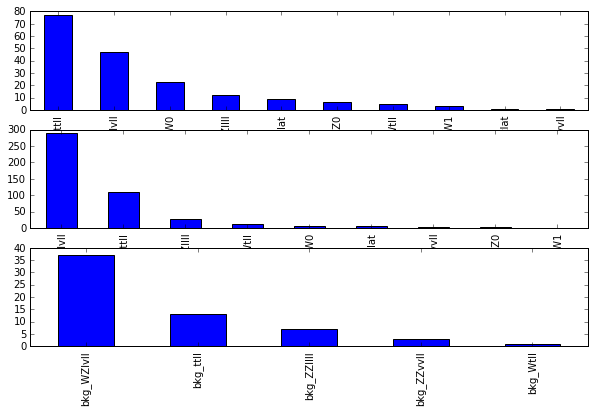

In [82]:
plt.clf()
fig = plt.figure(figsize=(10,1))
gs = gridspec.GridSpec(3, 1)
ax = plt.subplot(gs[0,:])
df_0.query('preds > 0.95 & is_sig == 0').cl.value_counts().plot(kind='bar')
ax = plt.subplot(gs[1,:])
df_1.query('preds > 0.9 & is_sig == 0').cl.value_counts().plot(kind='bar')
ax = plt.subplot(gs[2,:])
df_2.query('preds > 0.9 & is_sig == 0').cl.value_counts().plot(kind='bar')
#apply(pd.value_counts).plot(kind='bar', subplots=True)
#plt.hist(df_1.query('preds > 0.6').cl)